In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from PIL import Image
from skimage.transform import resize
from random import shuffle
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-18 18:28:29.830904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 18:28:29.831015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 18:28:29.951928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import keras
print(keras.__version__)


3.1.1


In [3]:
# Define the directory containing the dataset
directory = '/kaggle/input/cropped-faces/cropped_faces'

# Get the class names
class_names = os.listdir(directory)
num_classes = len(class_names)

# Select all the file paths
filepaths = [path for name in class_names for path in glob(os.path.join(directory, name, '*'))]
np.random.shuffle(filepaths)
print(f"Total number of images to be loaded: {len(filepaths)}")

Name = []

# Iterate through the files in the directory and extract the names
for file in os.listdir(directory):
    Name.append(file[5:])
print(Name)
print(len(Name))


Total number of images to be loaded: 16823
['Alex Lawther', 'Logan Lerman', 'Maria Pedraza', 'Anthony Mackie', 'Bobby Morley', 'Chris Evans', 'Chris Pratt', 'Mark Zuckerberg', 'Anne Hathaway', 'Emilia Clarke', 'Cristiano Ronaldo', 'Josh Radnor', 'Henry Cavil', 'Zoe Saldana', 'ellen page', 'Gwyneth Paltrow', 'Natalie Dormer', 'barbara palvin', 'Krysten Ritter', 'elon musk', 'Leonardo DiCaprio', 'Bill Gates', 'elizabeth olsen', 'Megan Fox', 'Taylor Swift', 'Tom Hiddleston', 'Jeremy Renner', 'melissa fumero', 'Robert Downey Jr', 'amber heard', 'Jake Mcdorman', 'Robert De Niro', 'grant gustin', 'Jennifer Lawrence', 'Eliza Taylor', 'scarlett johansson', 'Marie Avgeropoulos', 'Brenton Thwaites', 'Adriana Lima', 'Amanda Crew', 'Hugh Jackman', 'Katherine Langford', 'camila mendes', 'Selena Gomez', 'Avril Lavigne', 'jeff bezos', 'Jimmy Fallon', 'Christian Bale', 'Shakira Isabel Mebarak', 'Alvaro Morte', 'Lindsey Morgan', 'Zac Efron', 'Dominic Purcell', 'barack obama', 'Tom Holland', 'Emma Stone

In [4]:
import shutil

# Directory to be downloaded
folder_to_download = "/kaggle/working/cropped_faces"

# Destination path for the zip file
zip_file_path = "/kaggle/working/cropped_faces.zip"

# Create a zip file containing the folder
shutil.make_archive(zip_file_path.split('.')[0], 'zip', folder_to_download)

# Provide a link to download the zip file
print(f"Download the zip file from this link: {zip_file_path}")


Download the zip file from this link: /kaggle/working/cropped_faces.zip


In [5]:
N=[]
for i in range(len(Name)):
    N+=[i]

normal_mapping=dict(zip(Name,N))


print(dict(zip(N,Name)))

{0: 'Alex Lawther', 1: 'Logan Lerman', 2: 'Maria Pedraza', 3: 'Anthony Mackie', 4: 'Bobby Morley', 5: 'Chris Evans', 6: 'Chris Pratt', 7: 'Mark Zuckerberg', 8: 'Anne Hathaway', 9: 'Emilia Clarke', 10: 'Cristiano Ronaldo', 11: 'Josh Radnor', 12: 'Henry Cavil', 13: 'Zoe Saldana', 14: 'ellen page', 15: 'Gwyneth Paltrow', 16: 'Natalie Dormer', 17: 'barbara palvin', 18: 'Krysten Ritter', 19: 'elon musk', 20: 'Leonardo DiCaprio', 21: 'Bill Gates', 22: 'elizabeth olsen', 23: 'Megan Fox', 24: 'Taylor Swift', 25: 'Tom Hiddleston', 26: 'Jeremy Renner', 27: 'melissa fumero', 28: 'Robert Downey Jr', 29: 'amber heard', 30: 'Jake Mcdorman', 31: 'Robert De Niro', 32: 'grant gustin', 33: 'Jennifer Lawrence', 34: 'Eliza Taylor', 35: 'scarlett johansson', 36: 'Marie Avgeropoulos', 37: 'Brenton Thwaites', 38: 'Adriana Lima', 39: 'Amanda Crew', 40: 'Hugh Jackman', 41: 'Katherine Langford', 42: 'camila mendes', 43: 'Selena Gomez', 44: 'Avril Lavigne', 45: 'jeff bezos', 46: 'Jimmy Fallon', 47: 'Christian Ba

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/cropped_faces",
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    "/kaggle/working/cropped_faces",
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'
)


Found 14071 images belonging to 105 classes.
Found 3463 images belonging to 105 classes.


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from keras.optimizers import Adam
import requests
import os
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Load InceptionV3 base model without the top (classification) layer
base_model = InceptionV3(
    weights=None,  # Do not load weights from pre-trained model
    include_top=False,
    input_shape=(160, 160, 3)
)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Define additional layers
x = layers.Flatten()(base_model.output)

x = layers.Dense(1024, activation='elu')(x)
x = BatchNormalization()(x)

x = layers.Dense(512, activation='elu')(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='elu')(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

output_layer = Dense(105, activation='softmax')(x)

# Create the new model
new_model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the new model
new_model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

checkpoint_path = 'best_model.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_acc', save_best_only=True, mode='max')


# Display model summary
new_model.summary()

import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True 

callbacks = myCallback()

# Train the model
history = new_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, callbacks,model_checkpoint],
    batch_size=64
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 79, 79,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 79, 79,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 79, 79,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 77, 77,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 77, 77,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 77, 77,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 77, 77,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 77, 77,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 77, 77,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 38, 38,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 36, 36,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 36, 36,    │          0 │ batch_normalizat

 Total params: 41,288,841 (157.50 MB)

 Trainable params: 41,251,081 (157.36 MB)

 Non-trainable params: 37,760 (147.50 KB)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713465011.101970     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713465011.207121     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


257/440 ━━━━━━━━━━━━━━━━━━━━ 1:39 545ms/step - accuracy: 0.0116 - loss: 5.0955

W0000 00:00:1713465150.827703     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.0133 - loss: 5.0203

W0000 00:00:1713465219.690425     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713465263.897349     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


440/440 ━━━━━━━━━━━━━━━━━━━━ 336s 577ms/step - accuracy: 0.0133 - loss: 5.0200 - val_accuracy: 0.0139 - val_loss: 4.8663 - learning_rate: 1.0000e-04
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


440/440 ━━━━━━━━━━━━━━━━━━━━ 119s 266ms/step - accuracy: 0.0284 - loss: 4.6569 - val_accuracy: 0.0295 - val_loss: 4.9598 - learning_rate: 1.0000e-04
Epoch 3/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 119s 267ms/step - accuracy: 0.0332 - loss: 4.5139 - val_accuracy: 0.0459 - val_loss: 4.3586 - learning_rate: 1.0000e-04
Epoch 4/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 118s 265ms/step - accuracy: 0.0443 - loss: 4.3404 - val_accuracy: 0.0580 - val_loss: 4.3264 - learning_rate: 1.0000e-04
Epoch 5/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 118s 265ms/step - accuracy: 0.0643 - loss: 4.1687 - val_accuracy: 0.0679 - val_loss: 4.3097 - learning_rate: 1.0000e-04
Epoch 6/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 118s 265ms/step - accuracy: 0.0876 - loss: 3.9563 - val_accuracy: 0.0950 - val_loss: 3.8469 - learning_rate: 1.0000e-04
Epoch 7/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 119s 267ms/step - accuracy: 0.1203 - loss: 3.7355 - val_accuracy: 0.1288 - val_loss: 3.6728 - learning_rate: 1.0000e-04
Epoch 8/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 124s 277ms/

In [11]:
new_model.save('best_model.h5')

from IPython.display import FileLink 
FileLink(r'best_model.h5')

/kaggle/working/best_model.h5

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Get the predictions for the validation set
y_pred = new_model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true_classes = validation_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


  1/109 ━━━━━━━━━━━━━━━━━━━━ 10:40 6s/step

W0000 00:00:1713468741.578077     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step
Confusion Matrix:
[[0 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 1 1 0]
 [1 1 2 ... 1 0 1]
 [0 2 0 ... 1 1 0]]
Precision: 0.012352241599244689
Recall: 0.012705746462604677
F1 Score: 0.012347400200592475


W0000 00:00:1713468768.980233     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Testing the Model with an image not from the dataset


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\nabee\OneDrive\Desktop\deep learning\Lab4&5\cropped_faces",
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    r"C:\Users\nabee\OneDrive\Desktop\deep learning\Lab4&5\cropped_faces",
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'
)


Found 14071 images belonging to 105 classes.
Found 3463 images belonging to 105 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


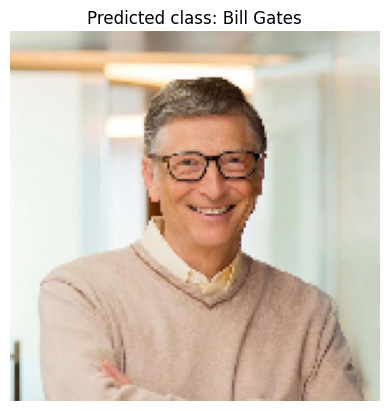

C:\Users\nabee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 241ms/step - accuracy: 0.6657 - loss: 1.3064
Test accuracy: 0.6621426343917847


In [ ]:
#### from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf



# Load the model
model_path = r"C:\Users\nabee\OneDrive\Desktop\deep learning\Lab4&5\best_model.h5"
new_model = tf.keras.models.load_model(model_path)

image_path = r"C:\Users\nabee\OneDrive\Desktop\billgates.jpg"

# Load the image and make a prediction
img = image.load_img(image_path, target_size=(160, 160))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the image

prediction = new_model.predict(img_array)
predicted_class_index = np.argmax(prediction)
class_labels =['Adriana Lima', 'Alex Lawther', 'Alexandra Daddario', 'Alvaro Morte', 'Amanda Crew', 'Andy Samberg', 'Anne Hathaway', 'Anthony Mackie', 'Avril Lavigne', 'Ben Affleck', 'Bill Gates', 'Bobby Morley', 'Brenton Thwaites', 'Brian J. Smith', 'Brie Larson', 'Chris Evans', 'Chris Hemsworth', 'Chris Pratt', 'Christian Bale', 'Cristiano Ronaldo', 'Danielle Panabaker', 'Dominic Purcell', 'Dwayne Johnson', 'Eliza Taylor', 'Elizabeth Lail', 'Emilia Clarke', 'Emma Stone', 'Emma Watson', 'Gwyneth Paltrow', 'Henry Cavil', 'Hugh Jackman', 'Inbar Lavi', 'Irina Shayk', 'Jake Mcdorman', 'Jason Momoa', 'Jennifer Lawrence', 'Jeremy Renner', 'Jessica Barden', 'Jimmy Fallon', 'Johnny Depp', 'Josh Radnor', 'Katharine Mcphee', 'Katherine Langford', 'Keanu Reeves', 'Krysten Ritter', 'Leonardo DiCaprio', 'Lili Reinhart', 'Lindsey Morgan', 'Lionel Messi', 'Logan Lerman', 'Madelaine Petsch', 'Maisie Williams', 'Maria Pedraza', 'Marie Avgeropoulos', 'Mark Ruffalo', 'Mark Zuckerberg', 'Megan Fox', 'Miley Cyrus', 'Millie Bobby Brown', 'Morena Baccarin', 'Morgan Freeman', 'Nadia Hilker', 'Natalie Dormer', 'Natalie Portman', 'Neil Patrick Harris', 'Pedro Alonso', 'Penn Badgley', 'Rami Malek', 'Rebecca Ferguson', 'Richard Harmon', 'Rihanna', 'Robert De Niro', 'Robert Downey Jr', 'Sarah Wayne Callies', 'Selena Gomez', 'Shakira Isabel Mebarak', 'Sophie Turner', 'Stephen Amell', 'Taylor Swift', 'Tom Cruise', 'Tom Hardy', 'Tom Hiddleston', 'Tom Holland', 'Tuppence Middleton', 'Ursula Corbero', 'Wentworth Miller', 'Zac Efron', 'Zendaya', 'Zoe Saldana', 'alycia dabnem carey', 'amber heard', 'barack obama', 'barbara palvin', 'camila mendes', 'elizabeth olsen', 'ellen page', 'elon musk', 'gal gadot', 'grant gustin', 'jeff bezos', 'kiernen shipka', 'margot robbie', 'melissa fumero', 'scarlett johansson', 'tom ellis']

predicted_class_label = class_labels[predicted_class_index]

# Display the image and the predicted class label
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_label}')
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = new_model.evaluate(validation_generator)
print(f'Test accuracy: {test_accuracy}')


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from PIL import Image
from random import shuffle
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from keras.optimizers import Adam
import os
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\nabee\OneDrive\Desktop\deep learning\Lab4&5\cropped_faces",
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    r"C:\Users\nabee\OneDrive\Desktop\deep learning\Lab4&5\105_classes_pins_dataset",
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'
)


Found 13503 images belonging to 105 classes.
Found 3463 images belonging to 105 classes.


In [10]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from keras.optimizers import Adam
import requests
import os
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
import tensorflow as tf


# Load InceptionV3 base model without the top (classification) layer
new_model = load_model(r"C:\Users\nabee\OneDrive\Desktop\deep learning\Lab4&5\best_model.h5")

# Unfreeze the last few layers for fine-tuning
# num_layers_to_unfreeze = 5  # Adjust this based on how many layers you want to retrain

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = True

# # Unfreeze the last `num_layers_to_unfreeze` layers
# for layer in base_model.layers[-num_layers_to_unfreeze:]:
#     layer.trainable = True

# Compile the new model
new_model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

checkpoint_path = 'best_model.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_acc', save_best_only=True, mode='max')

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True 

callbacks = myCallback()

# Train the model
history = new_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, callbacks,model_checkpoint],
    batch_size=64
)
new_model.save(r"C:\Users\nabee\OneDrive\Desktop\deep learning\Lab4&5\finetuning.h5")


C:\Users\nabee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.4878 - loss: 2.1340 - val_accuracy: 0.3801 - val_loss: 2.5866 - learning_rate: 1.0000e-04
Epoch 2/30


C:\Users\nabee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


422/422 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.5817 - loss: 1.6837 - val_accuracy: 0.4349 - val_loss: 2.3571 - learning_rate: 1.0000e-04
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.6132 - loss: 1.5627 - val_accuracy: 0.5151 - val_loss: 1.9244 - learning_rate: 1.0000e-04
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.6366 - loss: 1.4286 - val_accuracy: 0.5127 - val_loss: 1.9991 - learning_rate: 1.0000e-04
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.6664 - loss: 1.3497 - val_accuracy: 0.5024 - val_loss: 2.0979 - learning_rate: 1.0000e-04
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.6791 - loss: 1.2679 - val_accuracy: 0.5672 - val_loss: 1.7631 - learning_rate: 1.0000e-04
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.6969 - loss: 1.2008 - val_accuracy: 0.5792 - val_loss: 1.7352 - learning_rate: 1.0000e-04
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.71